### libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import os
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense
import csv
from keras.layers import Bidirectional
import tensorflow

In [2]:
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import statistics

In [3]:
from keras.layers import Input, Dense, Activation, Dropout,Lambda, LSTM, BatchNormalization, RNN
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [6]:
df = pd.read_csv('drive/My Drive/dinamic/train_set.csv', index_col=None)
categories = pd.read_csv('drive/My Drive/dinamic/mcc2big.csv', index_col=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## parameters

In [7]:
L_win = 4 
delta = 2

week_test = 19
week_train = 23
week_test_2 = 27

pred_cat = 63
n_timesteps = 4
parameter=4
num_month_client=3

NFILTERS = 64
lr = 0.001
BATCH_SIZE = 64
NB_EPOCH = 10

BiNFILTERS = 20
BiNB_EPOCH = 30
BIBATCH_SIZE = 32

OPTIM = Adam(learning_rate=lr)

BiNB_EPOCHS=30
BiBATCH_SIZE=32

## functions

### data processing

In [8]:
def preprocessing_week():
    #df is a set of transactions with the following fields:
    #amount, customer_id, mcc, transaction_date
    with open('drive/My Drive/dinamic/mcc2big.csv') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)
        catdict = {int(rows[0]): int(rows[1]) for rows in reader}
    df['MCC87'] = df['mcc'].map(catdict)
    df.dropna(inplace = True, subset = ['MCC87'])
    df['MCC87'] = df['MCC87'].astype('int')
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], infer_datetime_format = True)
    df['WEEK'] = df['transaction_date'].apply(lambda date: date.week)
    return df

def features_aggregation_week():
    data_sum = preproc_data_week.groupby(['customer_id', 'MCC87', 'WEEK'], as_index = False)['amount'].sum()
    data_sum['COUNT'] = preproc_data_week.groupby(['customer_id', 'MCC87', 'WEEK']).size().reset_index().iloc[:, -1]
    labels, uniques = pd.factorize(data_sum['customer_id'])
    data_sum['id'] = labels
    table_N = data_sum.pivot_table(index = ['id','WEEK'], columns = 'MCC87', values = 'COUNT', fill_value = 0).reset_index()
    return table_N

def window(in_group, ind_ar):
    istart = 0
    istop = L_win + 1   
    group = in_group.sort_values()    
    indices = group.index
    gr = group
    while istop <= len(group):
        m_start = gr.iloc[istart]
        m_stop = gr.iloc[istop - 1]
        if (m_stop - m_start) == L_win:
            add_data = [group.name, group.iloc[istop - 1]]           
            indxs = add_data + [it for it in indices[istart:istop]]
            ind_ar.append(indxs)
        istart += 1
        istop += 1
    return ind_ar   

In [9]:
def train_test_split_week(week_test, updating = False):
    ind_ar = []
    table.groupby('id')['WEEK'].apply(lambda x: window(x, ind_ar))
    df_indxs = pd.DataFrame(ind_ar, columns=['id','last_week'] + list(range(L_win + 1)))

    ind_test = df_indxs[(df_indxs['last_week'] >= week_test) & (df_indxs['last_week'] < week_train)]
    ind_test_2 = df_indxs[(df_indxs['last_week'] >= week_train) & (df_indxs['last_week'] < week_test_2)]

    if updating == True:
      ind_train = df_indxs[(df_indxs['last_week'] >= week_upd) & (df_indxs['last_week'] < week_test)]
    else:
      ind_train = df_indxs[(df_indxs['last_week'] >= 15) & (df_indxs['last_week'] < week_test)]

    return ind_test, ind_train, ind_test_2

In [10]:
def count_categories():
    NCATS = table.shape[1] - 2
    return NCATS

### data generator

In [11]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, df, indexes, L_win, NCATS, batch_size):
        self.data = df
        self.batch_size = batch_size
        self.ind = indexes
        self.L_win = L_win
        self.NCATS = NCATS
    
    def __len__(self):
        return int(np.floor(len(self.ind) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_ind = self.ind[idx * self.batch_size:(idx + 1) * self.batch_size]
        Ck = batch_ind[:, 0]
        month = batch_ind[:, 1] - 1
        ind_x = batch_ind[:, -(self.L_win + 1) : -1]
        ind_y = batch_ind[:, -1]

        X = self.data[ind_x, : ]
        Y = self.data[ind_y, :]
        Y = np.where(self.data[ind_y,:], 1, 0)
        X = X.reshape(self.batch_size, self.L_win, self.NCATS)
        Y = Y.reshape(self.batch_size, self.NCATS) 
        return [X, Ck, month], Y

### lstm predictor

In [12]:
def create_model():
    inp = Input(shape=(L_win, NCATS))
    inp_ck = Input(shape = (1, ))
    inp_m = Input(shape = (1, ))

    lay = LSTM(NFILTERS, return_sequences = True)(inp)
    lay2 = LSTM(NFILTERS)(lay)
    trg_clf = Dense(NCATS, activation = 'sigmoid')(lay2)

    model_clf = Model(inputs = [inp, inp_ck, inp_m], outputs = trg_clf)
    model_clf.compile(loss = 'binary_crossentropy', optimizer = OPTIM, metrics = ['accuracy']) 

    return model_clf   

def answers_for_classes(classA, classB):
    ind_test_A = ind_test[ind_test['id'].isin(classA)]
    ind_test_B = ind_test[ind_test['id'].isin(classB)]
    y_pred_A, y_true_A = get_answers_for_classes(ind_test_A)
    y_pred_B, y_true_B = get_answers_for_classes(ind_test_B)
    ind_cat = table.columns.get_loc(pred_cat) - 2
    return y_pred_A[:, ind_cat], y_true_A[:, ind_cat], y_pred_B[:, ind_cat], y_true_B[:, ind_cat]

def get_answers_for_classes(ind_test):
    model_RNN = create_model()
    model_RNN.load_weights("LSTM.h5")
    g_test = DataGenerator(table.values[:,2:], ind_test.values, L_win, NCATS, BATCH_SIZE)
    y_pred = model_RNN.predict_generator(generator=g_test)
    y_true = np.vstack([g_test[i][1] for i in range(len(g_test))])
    return y_pred, y_true

In [13]:
def train_and_predict(updating = False):
    g_train = DataGenerator(table.values[:, 2:], ind_train.values, L_win, NCATS, BATCH_SIZE)

    g_test = DataGenerator(table.values[:, 2:], ind_test.values, L_win, NCATS, BATCH_SIZE)
    g_test2 = DataGenerator(table.values[:, 2:], ind_test_2.values, L_win, NCATS, BATCH_SIZE)
  
    model_RNN = create_model()
    if updating == True:
      model_RNN.load_weights("drive/My Drive/dinamic/LSTM.h5")
    
    model_RNN.fit_generator(generator = g_train, validation_data = g_test, epochs = NB_EPOCH, verbose = 1)
    model_RNN.save_weights('drive/My Drive/dinamic/LSTM.h5')

    y_pred = model_RNN.predict_generator(generator = g_test)
    y_pred2 = model_RNN.predict_generator(generator = g_test2)
    y_true = np.vstack([g_test[i][1] for i in range(len(g_test))])
    ind_cat = table.columns.get_loc(pred_cat) - 2
    model_RNN.save_weights('LSTM.h5')
    return y_pred[:, ind_cat], y_true[:, ind_cat], y_pred2[:, ind_cat]

### class inferring

In [14]:
def count_coefficient():

  ind_test_loc, ind_train_loc = ind_test.copy(), ind_train.copy()
  ind_test_loc2 = ind_test_2.copy()

  #first interval
  ind_test_loc['target'] = table.values[ind_test_loc.values[:, -1], table.columns.get_loc(pred_cat)]
  ind_test_loc['target'] = np.where(ind_test_loc['target'], 1, 0)
  ind_test_loc['predicted_prob'] = np.zeros(len(ind_test_loc))
  ind_test_loc.iloc[:len(y_pred), ind_test_loc.columns.get_loc('predicted_prob')] = y_pred
  ind_test_loc = ind_test_loc[:len(y_pred)]
  ind_test_loc['num'] = abs(ind_test_loc['target'] - ind_test_loc['predicted_prob'])
  num = ind_test_loc.groupby('id')['num'].sum()
  den_n = ind_test_loc.groupby('id')['target'].count()
  CE = num / den_n
  CE = 1 - CE

  #the second interval
  ind_test_loc2['target'] = table.values[ind_test_loc2.values[:, -1], table.columns.get_loc(pred_cat)]
  ind_test_loc2['target'] = np.where(ind_test_loc2['target'], 1, 0)
  ind_test_loc2['predicted_prob'] = np.zeros(len(ind_test_loc2))
  ind_test_loc2.iloc[:len(y_pred2), ind_test_loc2.columns.get_loc('predicted_prob')] = y_pred2
  ind_test_loc2 = ind_test_loc2[:len(y_pred2)]
  ind_test_loc2['num'] = abs(ind_test_loc2['target'] - ind_test_loc2['predicted_prob'])
  num2 = ind_test_loc2.groupby('id')['num'].sum()
  den_n2 = ind_test_loc2.groupby('id')['target'].count()
  CE2 = num2 / den_n2
  CE2 = 1 - CE2
  return CE, CE2

def predictability_classes(CE):
    A, B = [], []
    for c_id, ce in CE.items():
        if (ce > statistics.median(CE)):
            A.append(c_id)
        else:
            B.append(c_id)
    return A, B   

### class identification

In [15]:
def train_test_split_for_class_identification():

    ind = np.arange(week_test, week_train)
    ind_test = np.arange(week_train, week_test_2)

    X_train = table[table['WEEK'].isin(ind)]
    X_train = X_train[X_train['id'].isin(CE.keys())]
    X_test = table[table['WEEK'].isin(ind_test)]
    X_test = X_test[X_test['id'].isin(CE2.keys())]

    num_months = X_test.groupby('id').size()
    valid_months = [c_id for c_id, num in num_months.items() if num > num_month_client]

    X_test = X_test[X_test['id'].isin(valid_months)]

    num_months_train = X_train.groupby('id').size()
    valid_months_train = [c_id for c_id, num in num_months_train.items() if num > num_month_client]

    X_train = X_train[X_train['id'].isin(valid_months_train)]

    test_ids = np.unique(X_test['id'])

    return X_train, X_test, test_ids

In [16]:
def reshape_train_and_test(updating = False):
    list_X, list_X_test = [], []
    X_train, X_test, test_ids = train_test_split_for_class_identification()

    un_ids = np.unique(X_train['id'])
    Y = np.zeros(len(un_ids))
    un_ids_test = np.unique(X_test['id'])
    for c_id in un_ids:
        cur = X_train[X_train['id'] == c_id][pred_cat].values
        list_X.append(cur)
    for i in range(len(un_ids)):
        if un_ids[i] in A:
            Y[i] = 0
        elif un_ids[i] in B:
            Y[i] = 1
    for i in range(len(list_X)):
        list_X[i] = list_X[i][-parameter:]
    X = np.vstack(list_X)
    X = X.reshape(len(list_X), n_timesteps, 1)
    Y = pd.get_dummies(Y).values
    Y = Y.reshape(len(list_X), 2)
    for c_id in un_ids_test:
        cur = X_test[X_test['id'] == c_id][pred_cat].values
        list_X_test.append(cur)
    
    for i in range(len(list_X_test)):
        list_X_test[i] = list_X_test[i][-parameter:]
    
    X_test_n = np.vstack(list_X_test)
    X_test_n = X_test_n.reshape(len(list_X_test), n_timesteps, 1)

    return X, Y, X_test_n, test_ids

In [17]:
def BiLSTM_model(updating = False):
    X, Y, X_test_n, test_ids = reshape_train_and_test(updating = updating)
    model = Sequential()
    model.add(Bidirectional(LSTM(BiNFILTERS, input_shape=(n_timesteps, 1), 
                                 return_sequences = False)))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    X = X.astype('float32')
    Y = Y.astype('float32')
    X_test_n = X_test_n.astype('float32')
    
    if updating == True:
      model(np.zeros((1,*X.shape[1:])))
      model.load_weights('drive/My Drive/dinamic/BiLSTM.h5')
    

    model.fit(X, Y, epochs = BiNB_EPOCHS, batch_size = BiBATCH_SIZE, verbose=2)
    
    model.save_weights('drive/My Drive/dinamic/BiLSTM.h5')
    yhat = model.predict(X_test_n).argmax(1)
    
    pred_A, pred_B = [], []
    for i in range(len(yhat)):
        if (yhat[i] == 0):
            pred_A.append(test_ids[i])
        else:
            pred_B.append(test_ids[i])
    return pred_A, pred_B

### evaluate results

In [18]:
def make_err_df(y_true, y_pred):
    return pd.DataFrame(np.vstack((y_true, y_pred)).transpose(), columns=['y_true','y_pred'])
    
def plot_PRC(errs, lim, colors, linestyles):
    recalls = {}
    for im, err in enumerate(errs):
        ytrue = err['y_true'].values 
        ypred = err['y_pred'].values

        precision, recall, thr = precision_recall_curve(ytrue, ypred)
        area = auc(recall, precision)
        clr = colors[im]
        lns = linestyles[im]
        plt.plot(recall, precision, linewidth = 2, color = clr, label = err.name, linestyle = lns)
                
        ind = np.argmin(recall > lim)    
        if ind < len(thr):
            r = recall[ind]
        recalls[err.name] = r
        
        plt.xlabel('Recall', fontsize = 20)
        plt.ylabel('Precision', fontsize = 20)
        plt.ylim(0, 1)
        plt.title('PR curve',size = 20,weight = 'bold')
        plt.legend()
    return recalls, precision[ind], thr[ind], area

In [19]:
def data_for_matrix(y_pred,threshold):
  y_pred_matrix=np.zeros(shape=y_pred.shape)
  for i in range(0,len(y_pred)):
    if y_pred[i]>threshold:
      y_pred_matrix[i]=1
  return y_pred_matrix

### spending prediction

In [20]:
def infer(updating = False):
    y_pred, y_true, y_pred2 = train_and_predict(updating = updating)
    CE, CE2 = count_coefficient()
    A, B = predictability_classes(CE)
    y_pred_A, y_true_A, y_pred_B, y_true_B = answers_for_classes(A, B)
    pred_A, pred_B = BiLSTM_model(updating = updating)
    y_pred_est_A, y_true_est_A, y_pred_est_B, y_true_est_B = answers_for_classes(pred_A, pred_B)

    return y_pred, y_true, y_pred_A, y_true_A, y_pred_B, y_true_B, y_pred_est_A, y_true_est_A, y_pred_est_B, y_true_est_B

# experiment

In [21]:
preproc_data_week = preprocessing_week()
table = features_aggregation_week()
NCATS = count_categories()

In [23]:
plt.rcParams["figure.figsize"] = [7, 5]
colors = ['k','g','r','g', 'r']
linestyles = ['-', '-', '-', '-', '-']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
164/164 [==============================] - 5s 14ms/step - loss: 0.1100 - accuracy: 0.2604 - val_loss: 0.0838 - val_accuracy: 0.2997
Epoch 2/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0830 - accuracy: 0.2756 - val_loss: 0.0832 - val_accuracy: 0.2997
Epoch 3/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0824 - accuracy: 0.2602 - val_loss: 0.0826 - val_accuracy: 0.2997
Epoch 4/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0818 - accuracy: 0.2516 - val_loss: 0.0820 - val_accuracy: 0.2615
Epoch 5/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0814 - accuracy: 0.2425 - val_loss: 0.0821 - val_accuracy: 0.2789
Epoch 6/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0811 - accuracy: 0.2447 - val_loss: 0.0820 - val_accuracy: 0.2526
Epoch 7/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0808 - accuracy: 0.2429 - val_loss: 0.0815 - val_accuracy: 0.2546

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/10
164/164 [==============================] - 5s 14ms/step - loss: 0.1114 - accuracy: 0.2586 - val_loss: 0.0842 - val_accuracy: 0.2997
Epoch 2/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0833 - accuracy: 0.2784 - val_loss: 0.0840 - val_accuracy: 0.2997
Epoch 3/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0832 - accuracy: 0.2784 - val_loss: 0.0835 - val_accuracy: 0.2997
Epoch 4/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0829 - accuracy: 0.2780 - val_loss: 0.0835 - val_accuracy: 0.2503
Epoch 5/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0824 - accuracy: 0.2761 - val_loss: 0.0826 - val_accuracy: 0.2997
Epoch 6/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0819 - accuracy: 0.2731 - val_loss: 0.0821 - val_accuracy: 0.2605
Epoch 7/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0811 - accuracy: 0.2392 - val_loss: 0.0814 - val_accuracy: 0.2532

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Epoch 1/30
116/116 - 4s - loss: 0.6564 - acc: 0.5660 - 4s/epoch - 33ms/step
Epoch 2/30
116/116 - 0s - loss: 0.5823 - acc: 0.7236 - 490ms/epoch - 4ms/step
Epoch 3/30
116/116 - 0s - loss: 0.5434 - acc: 0.7391 - 487ms/epoch - 4ms/step
Epoch 4/30
116/116 - 0s - loss: 0.5338 - acc: 0.7429 - 482ms/epoch - 4ms/step
Epoch 5/30
116/116 - 0s - loss: 0.5285 - acc: 0.7486 - 471ms/epoch - 4ms/step
Epoch 6/30
116/116 - 1s - loss: 0.5217 - acc: 0.7513 - 508ms/epoch - 4ms/step
Epoch 7/30
116/116 - 0s - loss: 0.5171 - acc: 0.7554 - 487ms/epoch - 4ms/step
Epoch 8/30
116/116 - 0s - loss: 0.5155 - acc: 0.7597 - 484ms/epoch - 4ms/step
Epoch 9/30
116/116 - 0s - loss: 0.5117 - acc: 0.7600 - 476ms/epoch - 4ms/step
Epoch 10/30
116/116 - 0s - loss: 0.5100 - acc: 0.7635 - 493ms/epoch - 4ms/step
Epoch 11/30
116/116 - 0s - loss: 0.5084 - acc: 0.7654 - 483ms/epoch - 4ms/step
Epoch 12/30
116/116 - 0s - loss: 0.5059 - acc: 0.7662 - 493ms/epoch - 4ms/step
Epoch 13/30
116/116 - 0s - loss: 0.5043 - acc: 0.7676 - 472ms/e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Step number  1


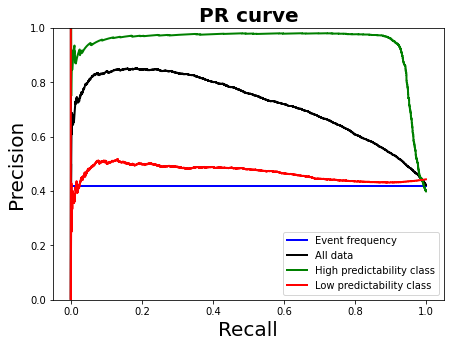

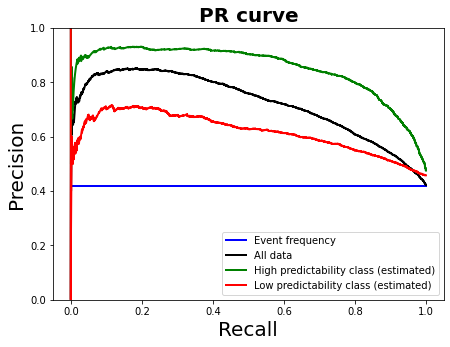

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
116/116 [==============================] - 5s 18ms/step - loss: 0.0805 - accuracy: 0.2846 - val_loss: 0.0837 - val_accuracy: 0.2311
Epoch 2/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0794 - accuracy: 0.2908 - val_loss: 0.0827 - val_accuracy: 0.2929
Epoch 3/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0783 - accuracy: 0.2924 - val_loss: 0.0807 - val_accuracy: 0.2910
Epoch 4/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0760 - accuracy: 0.2772 - val_loss: 0.0789 - val_accuracy: 0.2731
Epoch 5/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0745 - accuracy: 0.2790 - val_loss: 0.0781 - val_accuracy: 0.2737
Epoch 6/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0735 - accuracy: 0.2841 - val_loss: 0.0773 - val_accuracy: 0.2729
Epoch 7/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0728 - accuracy: 0.2883 - val_loss: 0.0768 - val_accuracy: 0.2705

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/10
116/116 [==============================] - 5s 19ms/step - loss: 0.0721 - accuracy: 0.2923 - val_loss: 0.0758 - val_accuracy: 0.2907
Epoch 2/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0703 - accuracy: 0.2943 - val_loss: 0.0755 - val_accuracy: 0.2848
Epoch 3/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0696 - accuracy: 0.2936 - val_loss: 0.0751 - val_accuracy: 0.2816
Epoch 4/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0690 - accuracy: 0.2931 - val_loss: 0.0751 - val_accuracy: 0.2817
Epoch 5/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0684 - accuracy: 0.2934 - val_loss: 0.0752 - val_accuracy: 0.2765
Epoch 6/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0681 - accuracy: 0.2946 - val_loss: 0.0752 - val_accuracy: 0.2794
Epoch 7/10
116/116 [==============================] - 1s 12ms/step - loss: 0.0676 - accuracy: 0.2953 - val_loss: 0.0752 - val_accuracy: 0.2716

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Epoch 1/30
119/119 - 4s - loss: 0.2873 - acc: 0.9088 - 4s/epoch - 34ms/step
Epoch 2/30
119/119 - 0s - loss: 0.2609 - acc: 0.9107 - 499ms/epoch - 4ms/step
Epoch 3/30
119/119 - 1s - loss: 0.2592 - acc: 0.9109 - 519ms/epoch - 4ms/step
Epoch 4/30
119/119 - 0s - loss: 0.2584 - acc: 0.9112 - 499ms/epoch - 4ms/step
Epoch 5/30
119/119 - 1s - loss: 0.2581 - acc: 0.9109 - 515ms/epoch - 4ms/step
Epoch 6/30
119/119 - 1s - loss: 0.2566 - acc: 0.9115 - 515ms/epoch - 4ms/step
Epoch 7/30
119/119 - 0s - loss: 0.2560 - acc: 0.9115 - 497ms/epoch - 4ms/step
Epoch 8/30
119/119 - 1s - loss: 0.2562 - acc: 0.9128 - 505ms/epoch - 4ms/step
Epoch 9/30
119/119 - 1s - loss: 0.2557 - acc: 0.9128 - 516ms/epoch - 4ms/step
Epoch 10/30
119/119 - 1s - loss: 0.2551 - acc: 0.9125 - 502ms/epoch - 4ms/step
Epoch 11/30
119/119 - 1s - loss: 0.2547 - acc: 0.9141 - 522ms/epoch - 4ms/step
Epoch 12/30
119/119 - 1s - loss: 0.2551 - acc: 0.9130 - 536ms/epoch - 5ms/step
Epoch 13/30
119/119 - 1s - loss: 0.2547 - acc: 0.9125 - 511ms/e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Step number  2


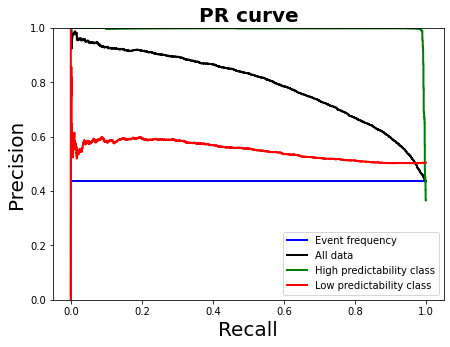

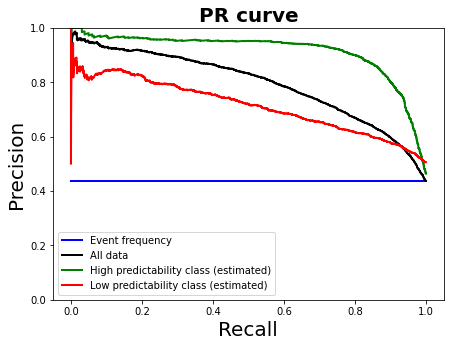

In [24]:
 for j in range(1,10): #9 steps
  if j == 1:
    updating_for_step = False
  else:
    updating_for_step = True

  ind_test, ind_train, ind_test_2 = train_test_split_week(week_test, updating = updating_for_step)
  y_pred, y_true, y_pred2 = train_and_predict(updating = updating_for_step)
  CE, CE2 = count_coefficient()
  A, B = predictability_classes(CE)
  y_pred_LSTM, y_true_LSTM, y_pred_A, y_true_A, y_pred_B, y_true_B, y_pred_est_A, y_true_est_A, y_pred_est_B, y_true_est_B = infer(updating = updating_for_step)

  larger_elements = [element for element in y_true_LSTM if element > 0]
  freq = len(larger_elements) / len(y_true_LSTM)

  err_RNN = make_err_df(y_true_LSTM, y_pred_LSTM)
  err_RNN.name = 'All data'

  err_RNN_A = make_err_df(y_true_A, y_pred_A)
  err_RNN_A.name = 'High predictability class'

  err_RNN_B = make_err_df(y_true_B, y_pred_B)
  err_RNN_B.name = 'Low predictability class'

  err_RNN_est_A = make_err_df(y_true_est_A, y_pred_est_A)
  err_RNN_est_A.name = 'High predictability class (estimated)'

  err_RNN_est_B = make_err_df(y_true_est_B, y_pred_est_B)
  err_RNN_est_B.name = 'Low predictability class (estimated)'

  print("Step number ", j)

  plt.plot([0, 1], [freq, freq], label = 'Event frequency', linewidth=2, linestyle='-', color = 'b')
  recalls = plot_PRC([err_RNN, err_RNN_A, err_RNN_B], 0.5, colors, linestyles)
  plt.show()
  plt.plot([0, 1], [freq, freq], label = 'Event frequency', linewidth=2, linestyle='-', color = 'b')
  recalls = plot_PRC([err_RNN, err_RNN_est_A, err_RNN_est_B], 0.5, colors, linestyles)
  plt.show()

  week_test = week_test + delta
  week_train = week_train + delta
  week_test_2 = week_test_2 + delta
  week_upd = week_test - delta